# Load the Data

In [2]:
import pandas as pd

# Load the data from the Excel file
data = pd.read_excel("Halifax_Typing_2023_09.xlsx")


# one_hot_encoding

In [3]:
# Extracting the features (inputs)
features = data.iloc[1:, 7:]

# One-hot encoding the features
encoded_features = pd.get_dummies(features, prefix=features.columns, drop_first=True)


In [4]:
encoded_features

,Low (inputs to prediction)_|11|,Low (inputs to prediction)_|1|,Low (inputs to prediction)_|23|,Low (inputs to prediction)_|24|,Low (inputs to prediction)_|25|,Low (inputs to prediction)_|26|,Low (inputs to prediction)_|29|,Low (inputs to prediction)_|2|,Low (inputs to prediction)_|30|,Low (inputs to prediction)_|31|,...,Unnamed: 12_|13|,Unnamed: 12_|14|,Unnamed: 12_|15|,Unnamed: 12_|16|,Unnamed: 12_|17|,Unnamed: 12_|1|,Unnamed: 12_|4|,Unnamed: 12_|7|,Unnamed: 12_|8|,Unnamed: 12_|9|
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1092,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1093,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1094,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Prepare the target data

In [5]:
from sklearn.preprocessing import LabelEncoder

# Extracting the target columns
targets = data.iloc[1:, :6]

# Initializing the LabelEncoder
label_encoders = {}

# Label encoding the target columns
encoded_targets = targets.copy()
for column in targets.columns:
    le = LabelEncoder()
    encoded_targets[column] = le.fit_transform(targets[column].astype(str))
    label_encoders[column] = le


In [6]:
encoded_targets

,High (What we're tryign to predict),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
1,7,23,0,6,15,34
2,7,23,0,33,14,34
3,0,6,0,2,35,34
4,1,23,24,27,28,34
5,1,6,0,6,3,34
...,...,...,...,...,...,...
1091,8,15,41,51,6,30
1092,1,9,41,51,12,29
1093,1,16,9,28,0,0
1094,16,28,10,41,6,13


## Train-Test Split

In [7]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(encoded_features, encoded_targets, test_size=0.2, random_state=42)

# Displaying the shapes of the training and testing sets to verify the split
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((876, 127), (219, 127), (876, 6), (219, 6))

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer


mlb = MultiLabelBinarizer()

y_train_multilabel = y_train.values.tolist()
y_test_multilabel = y_test.values.tolist()

# Fit and transform the training data
y_train_binarized = mlb.fit_transform(y_train_multilabel)

# Transform the testing data
y_test_binarized = mlb.transform(y_test_multilabel)

y_train_binarized.shape, y_test_binarized.shape


((876, 60), (219, 60))

# SEQ2SEQ_Model without EMbedding

In [104]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

# Define model parameters
batch_size = 64
epochs = 30
latent_dim = 256  
num_encoder_tokens = X_train.shape[1]
num_decoder_tokens = y_train_binarized.shape[1]

# Encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='sigmoid')  # Use sigmoid for binary outputs
decoder_outputs = decoder_dense(decoder_outputs)

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])  # Use binary_crossentropy for binary outputs

# Adjust data dimensions for training
X_train_enc = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
y_train_enc = y_train_binarized.reshape((y_train_binarized.shape[0], 1, y_train_binarized.shape[1]))

# Train the model
history=model.fit([X_train_enc, y_train_enc], y_train_enc,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)  


Epoch 1/30
11/11 [==============================] - 5s 100ms/step - loss: 0.6747 - accuracy: 0.1657 - val_loss: 0.6537 - val_accuracy: 0.4432
Epoch 2/30
11/11 [==============================] - 0s 19ms/step - loss: 0.6322 - accuracy: 0.6100 - val_loss: 0.5984 - val_accuracy: 0.6705
Epoch 3/30
11/11 [==============================] - 0s 19ms/step - loss: 0.5645 - accuracy: 0.6500 - val_loss: 0.5131 - val_accuracy: 0.7102
Epoch 4/30
11/11 [==============================] - 0s 18ms/step - loss: 0.4712 - accuracy: 0.6300 - val_loss: 0.4116 - val_accuracy: 0.6761
Epoch 5/30
11/11 [==============================] - 0s 19ms/step - loss: 0.3765 - accuracy: 0.5700 - val_loss: 0.3270 - val_accuracy: 0.6761
Epoch 6/30
11/11 [==============================] - 0s 18ms/step - loss: 0.3085 - accuracy: 0.5657 - val_loss: 0.2765 - val_accuracy: 0.6761
Epoch 7/30
11/11 [==============================] - 0s 19ms/step - loss: 0.2718 - accuracy: 0.5657 - val_loss: 0.2520 - val_accuracy: 0.6761
Epoch 8/30
1

In [106]:
# Adjusting the test set dimensions
X_test_enc = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_test_enc = y_test_binarized.reshape((y_test_binarized.shape[0], 1, y_test_binarized.shape[1]))

# Getting predictions
y_pred = model.predict([X_test_enc, y_test_enc])
y_pred_binarized = np.round(y_pred).reshape(y_pred.shape[0], y_pred.shape[2])


7/7 [==============================] - 1s 4ms/step


In [16]:
from nltk.translate.bleu_score import corpus_bleu

# Convert the binarized predictions and ground truth back to original labels
predicted_labels = [list(seq) for seq in mlb.inverse_transform(y_pred_binarized)]
true_labels = [list(seq) for seq in mlb.inverse_transform(y_test_binarized)]

# Preparing data for BLEU score calculation
references = [[label] for label in true_labels] # Actual labels
hypotheses = predicted_labels # Predicted labels

bleu_score = corpus_bleu(references, hypotheses)
print("BLEU Score:", bleu_score)


BLEU Score: 0.019545301952797085


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert predictions and ground truth to 1D arrays for metric calculation
y_true_1d = y_test_binarized.ravel()
y_pred_1d = y_pred_binarized.ravel()

# Accuracy
accuracy = accuracy_score(y_true_1d, y_pred_1d)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test_binarized, y_pred_binarized, average='samples')
print("Precision:", precision)

# Recall
recall = recall_score(y_test_binarized, y_pred_binarized, average='samples')
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test_binarized, y_pred_binarized, average='samples')
print("F1 Score:", f1)


Accuracy: 0.9331811263318113
Precision: 0.8531202435312023
Recall: 0.28797564687975646
F1 Score: 0.409976806552149


E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
from sklearn.metrics import hamming_loss

loss = hamming_loss(y_test_binarized, y_pred_binarized)
print("Hamming Loss:", loss)


Hamming Loss: 0.06681887366818874


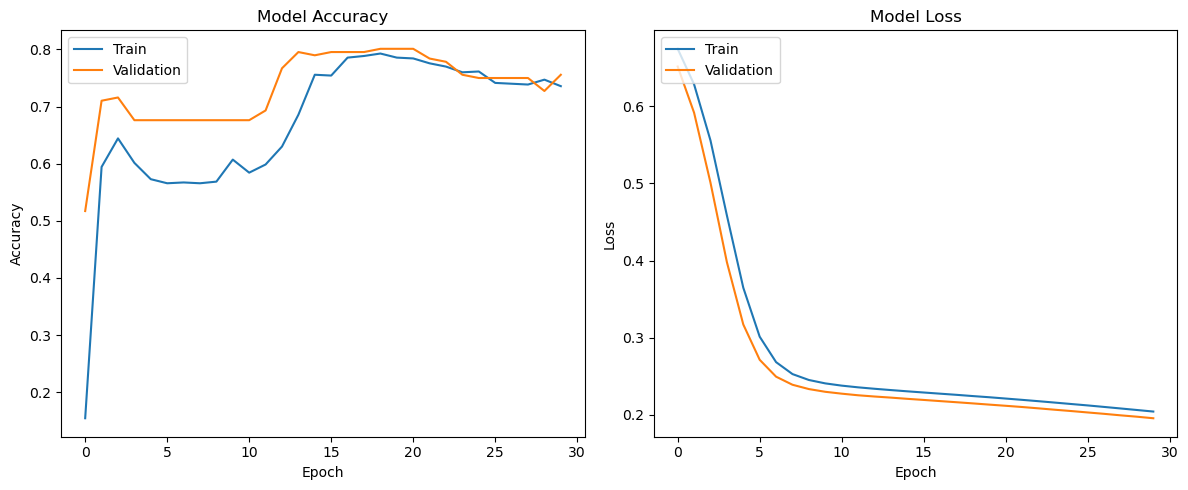

In [29]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


# SEQ2SEQ_Model- with Embedding

In [90]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model

# Encoder
encoder_inputs = Input(shape=(X_train.shape[1],))
embedding_dim = 100

encoder_embedding = Embedding(input_dim=num_encoder_tokens, output_dim=embedding_dim, mask_zero=True)(encoder_inputs)
encoder_dropout = Dropout(0.1)(encoder_embedding)
encoder_lstm = LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_dropout)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(y_train_binarized.shape[1],))  # Adjusted for binarized shape
decoder_embedding = Embedding(input_dim=num_decoder_tokens, output_dim=embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_outputs = decoder_outputs[:, -1, :]  # Consider only the last time step's output
decoder_dense = Dense(num_decoder_tokens, activation='sigmoid')
decoder_outputs = decoder_dense(decoder_outputs)

# Model
model1 = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using teacher forcing
model1.fit([X_train, y_train_binarized], y_train_binarized,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=([X_test, y_test_binarized], y_test_binarized))


Epoch 1/30
14/14 [==============================] - 49s 2s/step - loss: 0.6478 - accuracy: 0.4977 - val_loss: 0.4970 - val_accuracy: 0.6073
Epoch 2/30
14/14 [==============================] - 30s 2s/step - loss: 0.3122 - accuracy: 0.5879 - val_loss: 0.2532 - val_accuracy: 0.6073
Epoch 3/30
14/14 [==============================] - 29s 2s/step - loss: 0.2487 - accuracy: 0.5879 - val_loss: 0.2480 - val_accuracy: 0.6073
Epoch 4/30
14/14 [==============================] - 31s 2s/step - loss: 0.2457 - accuracy: 0.5879 - val_loss: 0.2473 - val_accuracy: 0.6073
Epoch 5/30
14/14 [==============================] - 31s 2s/step - loss: 0.2448 - accuracy: 0.5879 - val_loss: 0.2466 - val_accuracy: 0.6073
Epoch 6/30
14/14 [==============================] - 31s 2s/step - loss: 0.2445 - accuracy: 0.5879 - val_loss: 0.2462 - val_accuracy: 0.6073
Epoch 7/30
14/14 [==============================] - 31s 2s/step - loss: 0.2442 - accuracy: 0.5879 - val_loss: 0.2454 - val_accuracy: 0.6073
Epoch 8/30
14/14 [==

# Evaluation

In [91]:
# Evaluate the model on the test data
loss, accuracy = model1.evaluate([X_test, y_test_binarized], y_test_binarized, batch_size=batch_size)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


4/4 [==============================] - 2s 528ms/step - loss: 0.2441 - accuracy: 0.6073
Test Loss: 0.2441
Test Accuracy: 0.6073


In [92]:
model1.summary()


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_40 (InputLayer)          [(None, 127)]        0           []                               
                                                                                                  
 embedding_30 (Embedding)       (None, 127, 100)     12700       ['input_40[0][0]']               
                                                                                                  
 input_41 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 dropout_9 (Dropout)            (None, 127, 100)     0           ['embedding_30[0][0]']           
                                                                                           

In [31]:
print("Shape of y_pred:", y_pred.shape)


Shape of y_pred: (219, 60)


In [33]:
# No need to reshape y_pred
y_pred_binarized = np.round(y_pred)

predicted_labels = [list(seq) for seq in mlb.inverse_transform(y_pred_binarized)]

# Convert true labels to list format for BLEU calculation
true_labels = [list(seq) for seq in mlb.inverse_transform(y_test_binarized)]

references = [[label] for label in true_labels]
hypotheses = predicted_labels

bleu_score = corpus_bleu(references, hypotheses, smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method1)
print("BLEU Score:", bleu_score)


BLEU Score: 0.00010502668304724247


In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, jaccard_score

# Predictions were already binarized as y_pred_binarized
# Convert true multi-label outputs back to binary format for metric calculations
# (assuming y_test_binarized is already binarized)

# Precision, Recall, and F1 Score
precision = precision_score(y_test_binarized, y_pred_binarized, average='samples')
recall = recall_score(y_test_binarized, y_pred_binarized, average='samples')
f1 = f1_score(y_test_binarized, y_pred_binarized, average='samples')

# Hamming Loss
hamming = hamming_loss(y_test_binarized, y_pred_binarized)

# Jaccard Similarity
jaccard = jaccard_score(y_test_binarized, y_pred_binarized, average='samples')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Hamming Loss: {hamming:.4f}")
print(f"Jaccard Similarity: {jaccard:.4f}")

Precision: 0.5822
Recall: 0.1196
F1 Score: 0.1940
Hamming Loss: 0.0882
Jaccard Similarity: 0.1157


# Model with Bi-directional LSTM

In [13]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Bidirectional
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
dropout_rate=0.5
# Define model parameters
encoder_inputs = Input(shape=(X_train.shape[1],))
embedding_dim = 100
batch_size = 64
latent_dim = 256  
num_encoder_tokens = X_train.shape[1]
num_decoder_tokens = y_train_binarized.shape[1]

# Encoder
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(input_dim=num_encoder_tokens, output_dim=latent_dim)(encoder_inputs)
encoder_lstm = Bidirectional(LSTM(latent_dim, return_state=True, dropout=dropout_rate))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embedding)

# Concatenate the forward and backward states
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=num_decoder_tokens, output_dim=latent_dim)(decoder_inputs)
decoder_lstm = LSTM(2*latent_dim, return_sequences=True, return_state=True, dropout=dropout_rate)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_outputs = Dropout(dropout_rate)(decoder_outputs)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Model
model2 = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model2.summary()

# Train the model
model2.fit(
    [X_train, y_train_binarized],
    y_train_binarized,
    batch_size=batch_size,
    epochs=30,
    validation_data=([X_test, y_test_binarized], y_test_binarized,)
    
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    32512       ['input_4[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 512),        1050624     ['embedding[0][0]']              
                                 (None, 256),                                                 

In [14]:
from nltk.translate.bleu_score import corpus_bleu
from sklearn.preprocessing import MultiLabelBinarizer

y_pred = model2.predict([X_test, y_test_binarized])

#  Convert to binary format based on a threshold (e.g., 0.5,1.0)
y_pred_binarized = (y_pred > 1.0).astype(int)

#  Convert the binarized predictions and true values to actual labels
mlb = MultiLabelBinarizer()
# Combine training and testing labels for refitting
all_labels = y_train_multilabel + y_test_multilabel

# Fit the mlb with all labels
mlb.fit(all_labels)

# Extract the last time step from y_pred_binarized
y_pred_last_timestep = y_pred_binarized[:, -1, :]

# Convert the binarized predictions of the last time step and true values to actual labels
y_pred_labels = [list(filter(None, labels)) for labels in mlb.inverse_transform(y_pred_last_timestep)]
y_test_labels = [list(filter(None, labels)) for labels in mlb.inverse_transform(y_test_binarized)]

# Convert to list of list format for corpus_bleu
y_test_labels_list = [[label] for label in y_test_labels]

# Calculate the corpus BLEU score
from nltk.translate.bleu_score import corpus_bleu
bleu_score = corpus_bleu(y_test_labels_list, y_pred_labels)
print("Corpus BLEU Score:", bleu_score)


7/7 [==============================] - 4s 441ms/step
Corpus BLEU Score: 0


In [17]:
# Predict the outputs for the test set
y_pred = model2.predict([X_test, y_test_binarized])


7/7 [==============================] - 3s 500ms/step


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss
import numpy as np
# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=-1)

# Flatten the arrays to compare each element
y_true_flat = y_test_binarized.flatten()
y_pred_flat = y_pred_labels.flatten()

# Calculate Accuracy, Precision, Recall, and F1 score
accuracy = accuracy_score(y_true_flat, y_pred_flat)
precision = precision_score(y_true_flat, y_pred_flat, average='micro')
recall = recall_score(y_true_flat, y_pred_flat, average='micro')
f1 = f1_score(y_true_flat, y_pred_flat, average='micro')

# Calculate Hamming Loss
hamming = hamming_loss(y_true_flat, y_pred_flat)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Hamming Loss: {hamming:.4f}')


Accuracy: 1.00
Precision: 1.00
Recall: 1.0000
F1 Score: 1.0000
Hamming Loss: 0.0000


# Model with 3-RNN layers

In [26]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Input, Dropout
from tensorflow.keras.models import Model

# Parameters
latent_dim = 256
dropout_rate = 0.5

# Encoder
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(input_dim=num_encoder_tokens, output_dim=latent_dim)(encoder_inputs)

# Encoder with 3 RNN layers
encoder_rnn1 = SimpleRNN(latent_dim, return_sequences=True, dropout=dropout_rate, return_state=True)
encoder_outputs1, encoder_state1 = encoder_rnn1(encoder_embedding)

encoder_rnn2 = SimpleRNN(latent_dim, return_sequences=True, dropout=dropout_rate, return_state=True)
encoder_outputs2, encoder_state2 = encoder_rnn2(encoder_outputs1)

encoder_rnn3 = SimpleRNN(latent_dim, return_state=True, dropout=dropout_rate)
encoder_outputs, encoder_state = encoder_rnn3(encoder_outputs2)

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=num_decoder_tokens, output_dim=latent_dim)(decoder_inputs)

# Decoder with 3 RNN layers
decoder_rnn1 = SimpleRNN(latent_dim, return_sequences=True, dropout=dropout_rate, return_state=True)
decoder_outputs1, _ = decoder_rnn1(decoder_embedding, initial_state=encoder_state)

decoder_rnn2 = SimpleRNN(latent_dim, return_sequences=True, dropout=dropout_rate, return_state=True)
decoder_outputs2, _ = decoder_rnn2(decoder_outputs1, initial_state=encoder_state)

decoder_rnn3 = SimpleRNN(latent_dim, return_sequences=True, dropout=dropout_rate, return_state=True)
decoder_outputs, _ = decoder_rnn3(decoder_outputs2, initial_state=encoder_state)

decoder_outputs = Dropout(dropout_rate)(decoder_outputs)
decoder_dense = Dense(num_decoder_tokens, activation='sigmoid')
decoder_outputs = decoder_dense(decoder_outputs)

# Model
model3 = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.summary()

# Train the model
model3.fit(
    [X_train, y_train_binarized],
    y_train_binarized,
    batch_size=batch_size,
    epochs=30,
    validation_data=([X_test, y_test_binarized], y_test_binarized,)
)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 256)    32512       ['input_6[0][0]']                
                                                                                                  
 simple_rnn (SimpleRNN)         [(None, None, 256),  131328      ['embedding_2[0][0]']            
                                 (None, 256)]                                                     
                                                                                                  
 input_7 (InputLayer)           [(None, None)]       0           []                         

In [27]:
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.translate.bleu_score import corpus_bleu

y_pred = model3.predict([X_test, y_test_binarized])

y_pred_binarized = (y_pred[:, -1, :] > 0.5).astype(int)

y_pred_multilabel = mlb.inverse_transform(y_pred_binarized)
y_test_multilabel = mlb.inverse_transform(y_test_binarized)

references = [[seq] for seq in y_test_multilabel]
hypotheses = y_pred_multilabel
# Compute the BLEU score
bleu_score = corpus_bleu(references, hypotheses)
print("Corpus BLEU Score:", bleu_score)


7/7 [==============================] - 1s 109ms/step
Corpus BLEU Score: 1.5589834751968717e-155


E:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
E:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [76]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss

# Generate predictions on the test set
y_pred = model3.predict([X_test, y_test_binarized])

# Binarize the predictions
y_pred_binarized = (y_pred[:, -1, :] > 0.5).astype(int)

# Calculate metrics
precision = precision_score(y_test_binarized, y_pred_binarized, average='micro')
recall = recall_score(y_test_binarized, y_pred_binarized, average='micro')
f1 = f1_score(y_test_binarized, y_pred_binarized, average='micro')
hamming = hamming_loss(y_test_binarized, y_pred_binarized)

print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")
print(f"Hamming Loss: {hamming:.5f}")


7/7 [==============================] - 1s 120ms/step
Precision: 60.73%
Recall: 11.12%
F1 Score: 18.80%
Hamming Loss: 0.08744
